# Airline On-Time Performance (ATP) Project
**draft starter notebook for preparing the data by James G. Shanahan**



* Database Name: Airline On-Time Performance Data
* https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr
* Reporting carriers are required to (or voluntarily) report on-time data for flights they operate: on-time arrival and departure data for non-stop domestic flights by month and year, by carrier and by origin and destination airport. Includes scheduled and actual departure and arrival times, canceled and diverted flights, taxi-out and taxi-in times, causes of delay and cancellation, air time, and non-stop distance.
* Use Download for individual flight data.
  * https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr
* DAILY:  15-20,000 commercial passenger domestic US  flights  out of 87,000 flights
  * Commercial makes up 35% of all flights
  * Private planes (30%)
  * Air taxi flights (planes for hire),
•5,260 military flights and
•2,148 air cargo flights (Federal Express, UPS, etc.)
•Src: https://www.answerbag.com/q_view/34532


In [ ]:
# STEP 1: run this cell first and it requires input from you
#         before you can proceed with the other cells
# STEP 2: respond to the series of two/three popups authorizing access to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# run this cell as is to install PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=d4afdfba095474b9d8189d4b80bfd16829c0f3ee0d6d730600925a9aa664bbef
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Start PySpark
#from pyspark.sql import SparkSession
#spark = SparkSession.builder\
#    .master("local")\
#    .appName("OTP_starter_phase")\
#    .config('spark.ui.port', '4050')\
#    .getOrCreate()

In [ ]:
# Start PySpark
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'OTP_starter_phase'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .config('spark.ui.port', '4050')\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext


starting Spark


# Dataframes: a mini review

In [ ]:
# TEST write to blob storage
# Write CSV file with column header (column names)

from pyspark.sql.types import StructType,StructField, StringType, IntegerType
data2 = [("James","","Smith","36636","M",3000),
    ("Michael","Rose","","40288","M",4000),
    ("Robert","","Williams","42114","M",4000),
    ("Maria","Anne","Jones","39192","F",4000),
    ("Jen","Mary","Brown","","F",-1)
  ]

schema = StructType([ \
    StructField("firstname",StringType(),True), \
    StructField("middlename",StringType(),True), \
    StructField("lastname",StringType(),True), \
    StructField("id", StringType(), True), \
    StructField("gender", StringType(), True), \
    StructField("salary", IntegerType(), True) \
  ])

df = spark.createDataFrame(data=data2,schema=schema)
df.printSchema()
df.show(truncate=False)

# two CSV PART00000 file
df.repartition(2).write.mode('overwrite').options(header='True', delimiter=',')  \
 .csv(f"test_tmp_csv")
!ls -l test_tmp_csv # two part-0000


root
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: integer (nullable = true)

+---------+----------+--------+-----+------+------+
|firstname|middlename|lastname|id   |gender|salary|
+---------+----------+--------+-----+------+------+
|James    |          |Smith   |36636|M     |3000  |
|Michael  |Rose      |        |40288|M     |4000  |
|Robert   |          |Williams|42114|M     |4000  |
|Maria    |Anne      |Jones   |39192|F     |4000  |
|Jen      |Mary      |Brown   |     |F     |-1    |
+---------+----------+--------+-----+------+------+

total 8
-rw-r--r-- 1 root root  98 Mar 23 14:48 part-00000-2e0b899b-ae32-4a55-890a-62ceba2dbcf2-c000.csv
-rw-r--r-- 1 root root 138 Mar 23 14:48 part-00001-2e0b899b-ae32-4a55-890a-62ceba2dbcf2-c000.csv
-rw-r--r-- 1 root root   0 Mar 23 14:48 _SUCCESS


In [ ]:
# example from
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

simpleData = (("James", "Sales", 3000), \
    ("Michael", "Sales", 4600),  \
    ("Robert", "Sales", 4100),   \
    ("Maria", "Finance", 3000),  \
    ("James", "Sales", 3000),    \
    ("Scott", "Finance", 3300),  \
    ("Jen", "Finance", 3900),    \
    ("Jeff", "Marketing", 3000), \
    ("Kumar", "Marketing", 2000),\
    ("Saif", "Sales", 4100) \
  )

columns= ["employee_name", "department", "salary"]

df = spark.createDataFrame(data = simpleData, schema = columns)

df.printSchema()
df.show(truncate=False)

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
windowSpec  = Window.partitionBy("department").orderBy("salary")

df.withColumn("row_number",row_number().over(windowSpec)) \
    .show(truncate=False)

from pyspark.sql.functions import rank
df.withColumn("rank",rank().over(windowSpec)) \
    .show()

from pyspark.sql.functions import dense_rank
df.withColumn("dense_rank",dense_rank().over(windowSpec)) \
    .show()

from pyspark.sql.functions import percent_rank
df.withColumn("percent_rank",percent_rank().over(windowSpec)) \
    .show()

from pyspark.sql.functions import ntile
df.withColumn("ntile",ntile(2).over(windowSpec)) \
    .show()

from pyspark.sql.functions import cume_dist
df.withColumn("cume_dist",cume_dist().over(windowSpec)) \
   .show()

from pyspark.sql.functions import lag
df.withColumn("lag",lag("salary",2).over(windowSpec)) \
      .show()

from pyspark.sql.functions import lead
df.withColumn("lead",lead("salary",2).over(windowSpec)) \
    .show()

windowSpecAgg  = Window.partitionBy("department")
from pyspark.sql.functions import col,avg,sum,min,max,row_number
df.withColumn("row",row_number().over(windowSpec)) \
  .withColumn("avg", avg(col("salary")).over(windowSpecAgg)) \
  .withColumn("sum", sum(col("salary")).over(windowSpecAgg)) \
  .withColumn("min", min(col("salary")).over(windowSpecAgg)) \
  .withColumn("max", max(col("salary")).over(windowSpecAgg)) \
  .where(col("row")==1).select("department","avg","sum","min","max") \
  .show()

root
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)

+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000  |
|Michael      |Sales     |4600  |
|Robert       |Sales     |4100  |
|Maria        |Finance   |3000  |
|James        |Sales     |3000  |
|Scott        |Finance   |3300  |
|Jen          |Finance   |3900  |
|Jeff         |Marketing |3000  |
|Kumar        |Marketing |2000  |
|Saif         |Sales     |4100  |
+-------------+----------+------+

+-------------+----------+------+----------+
|employee_name|department|salary|row_number|
+-------------+----------+------+----------+
|Maria        |Finance   |3000  |1         |
|Scott        |Finance   |3300  |2         |
|Jen          |Finance   |3900  |3         |
|Kumar        |Marketing |2000  |1         |
|Jeff         |Marketing |3000  |2         |
|James        |Sales     |3000  |1

In [ ]:
# one CSV PART00000 file only
df.repartition(1).write.mode('overwrite').options(header='True', delimiter=',')  \
 .csv(f"test_tmp_csv")

In [ ]:
!ls -l test_tmp_csv

total 4
-rw-r--r-- 1 root root 189 Mar 13 23:56 part-00000-a5bf178f-93cd-4097-b6aa-f397c71e10c9-c000.csv
-rw-r--r-- 1 root root   0 Mar 13 23:56 _SUCCESS


In [ ]:
!head test_tmp_csv/part-00000-*.csv


firstname,middlename,lastname,id,gender,salary
Maria,Anne,Jones,39192,F,4000
Jen,Mary,Brown,"",F,-1


In [ ]:
# for more backgroup on pandas_udf please see:
#    https://learn.microsoft.com/en-us/azure/databricks/udf/pandas
from typing import Iterator, Tuple
import pandas as pd
from pyspark.sql.functions import col, pandas_udf, struct, concat_ws,lit

pdf = pd.DataFrame([[1, 2, 3, "Jane"], [2, 2,2, None], [12, 12,12, "John"]], columns=["x", "y", "z", "a_string"])
df = spark.createDataFrame(pdf)
df.createOrReplaceTempView("vw_df")
pdf2 = pd.DataFrame([[1, 2, 3], [2, 2,2], [12, 12,12], [55,55,55]], columns=["x", "y", "z"])
df2 = spark.createDataFrame(pdf2)
df2.createOrReplaceTempView("vw_df2")


@pandas_udf("long")
def multiply_two_cols(
        iterator: Iterator[Tuple[pd.Series, pd.Series]]) -> Iterator[pd.Series]:
    for a, b in iterator:
        yield a * b

df.select(multiply_two_cols("x", "y")).show()


# select: Projects a set of expressions and returns a new DataFrame.
#   NOTE: If one of the column names is '*', that column is expanded
#   to include all columns in the current DataFrame.
df.select(concat_ws(",",df.x,df.y).alias("x_y"), \
          df.x, df.y,  lit(df.x*2).alias("x_BY_2"), \
          multiply_two_cols("x","y").alias("x_BY_y")).show()

# include all the old columns
old_and_new_sdf = df.select("*", concat_ws(",",df.x,df.y).alias("x_y"), \
          df.x, df.y,  lit(df.x*2).alias("x_BY_2"), \
          multiply_two_cols("x","y").alias("x_BY_y") \
          )
old_and_new_sdf.show()
old_and_new_sdf.createOrReplaceTempView("vw_old_and_new_sdf")


# Using UDF with withColumn()
#   Returns a new DataFrame by adding a column or replacing the
#   existing column that has the same name.
df.withColumn("x_y",multiply_two_cols("x","y")).show()

# +-----------------------+
# |multiply_two_cols(x, x)|
# +-----------------------+
# |                      1|
# |                      4|
# |                      9|
# +-----------------------+

+-----------------------+
|multiply_two_cols(x, y)|
+-----------------------+
|                      2|
|                      4|
|                    144|
+-----------------------+

+-----+---+---+------+------+
|  x_y|  x|  y|x_BY_2|x_BY_y|
+-----+---+---+------+------+
|  1,2|  1|  2|     2|     2|
|  2,2|  2|  2|     4|     4|
|12,12| 12| 12|    24|   144|
+-----+---+---+------+------+

+---+---+---+--------+-----+---+---+------+------+
|  x|  y|  z|a_string|  x_y|  x|  y|x_BY_2|x_BY_y|
+---+---+---+--------+-----+---+---+------+------+
|  1|  2|  3|    Jane|  1,2|  1|  2|     2|     2|
|  2|  2|  2|    null|  2,2|  2|  2|     4|     4|
| 12| 12| 12|    John|12,12| 12| 12|    24|   144|
+---+---+---+--------+-----+---+---+------+------+

+---+---+---+--------+---+
|  x|  y|  z|a_string|x_y|
+---+---+---+--------+---+
|  1|  2|  3|    Jane|  2|
|  2|  2|  2|    null|  4|
| 12| 12| 12|    John|144|
+---+---+---+--------+---+



In [ ]:
#check which are rows are present in df2 and not in df
sql= """SELECT * FROM vw_df2
         EXCEPT
        SELECT * FROM vw_df"""
diff = spark.sql(sql).cache()
diff.show()

AnalysisException: ignored

In [ ]:
from pyspark.sql.functions import col,isnan,when,count
# Get a tally on the missing values
old_and_new_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in old_and_new_sdf.columns]).show()


In [ ]:
from pyspark.sql.functions import col,isnan,when,count

old_and_new_sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in old_and_new_sdf.columns]).show()



+---+---+---+---+---+---+------+------+
|  x|  y|  z|x_y|  x|  y|x_BY_2|x_BY_y|
+---+---+---+---+---+---+------+------+
|  0|  0|  0|  0|  0|  0|     0|     0|
+---+---+---+---+---+---+------+------+



In [ ]:
# 	two_hours_prior_depart_UTC	four_hours_prior_depart_UTC
#1	2015-01-01T16:00:00	2015-01-01T14:00:00
"2015-01-01T14:00:00" < "2015-01-01T14:52:00" and "2015-01-01T14:52:00" <  "2015-01-01T16:00:00"

True

In [ ]:
display(df.toPandas())

,x,y,z
0,1,2,3
1,2,2,2
2,12,12,12


# Download Data (for one day 2015-01-01)
* Raw flight data has been augmented with
   * the nearest weather station,
   * scheduled departure  in UTC time
   * scheduled departure  in UTC time -2 hours and -4  hours (prior to scheduled departure)

* Raw Weather data is provided as is
  * Weather records are filtered based on the 400 US airports of interest (1 TeraByte of data (uncompressed) is reduced to 2-3 Gig compressed.
  * Question: what time is each weather record in? Local? UTC?


## Download weather data (for one day 2015-01-01)


In [ ]:
!wget -O weather_2015_01_01.csv  https://www.dropbox.com/s/9t6nvxqw7dshvet/Weather_1_day.csv?dl=0

--2023-03-14 14:51:43--  https://www.dropbox.com/s/9t6nvxqw7dshvet/Weather_1_day.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9t6nvxqw7dshvet/Weather_1_day.csv [following]
--2023-03-14 14:51:43--  https://www.dropbox.com/s/raw/9t6nvxqw7dshvet/Weather_1_day.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb94e136970432bd0cca9919b87.dl.dropboxusercontent.com/cd/0/inline/B4M4lZTJiHC-F5CLbz4YynrP4SkL0VTP8tg5QHSiJv9-wFq36il9vUrWXeoCBg1jegHRr91CyXRnuAV7su9bIgmJ8Yl4ZSDXTxD0Q-9pJlDmNy8yXsE-Bnxwz9t_tE9G6Tc7Fn7E8DA6bwZL2QMbJvBww0Mwt_hhVqsY14sLVlCcWQ/file# [following]
--2023-03-14 14:51:44--  https://ucb94e136970432bd0cca9919b87.dl.dropboxusercontent.com/cd/0/inline/B4M4lZTJiHC-F5CLbz4YynrP4SkL0VTP8tg5QHSiJv9-wFq36il9vUrWXeoC

In [ ]:
!head weather_2015_01_01.csv
!wc -l weather_2015_01_01.csv # number of weather records (includes header!)

STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,DailyAverageWindSpeed,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,DailyWeather,MonthlyAverageRH,MonthlyDaysWithGT001Precip,MonthlyDaysWithGT0

In [ ]:
df_weather = spark.read.option("header",True) \
                       .option("delimiter",",") \
               .csv(f"weather_2015_01_01.csv").cache()
df_weather.createOrReplaceTempView("vw_weather")
sql = """
SELECT *
FROM vw_weather
LIMIT 10
"""
df_weather_tmp  = spark.sql(sql).cache()
#display(df_weather_tmp.toPandas())
display(df_weather_tmp.toPandas().transpose(), exclude="None")

,0,1,2,3,4,5,6,7,8,9
STATION,52652099999,52652099999,52652099999,52652099999,52652099999,52652099999,52652099999,52652099999,30499099999,30499099999
DATE,2015-01-01T02:00:00,2015-01-01T05:00:00,2015-01-01T08:00:00,2015-01-01T11:00:00,2015-01-01T14:00:00,2015-01-01T17:00:00,2015-01-01T20:00:00,2015-01-01T23:00:00,2015-01-01T00:00:00,2015-01-01T03:00:00
LATITUDE,39.0833333,39.0833333,39.0833333,39.0833333,39.0833333,39.0833333,39.0833333,39.0833333,55.1833333,55.1833333
LONGITUDE,100.2833333,100.2833333,100.2833333,100.2833333,100.2833333,100.2833333,100.2833333,100.2833333,124.6666666,124.6666666
ELEVATION,1462.0,1462.0,1462.0,1462.0,1462.0,1462.0,1462.0,1462.0,528.0,528.0
...,...,...,...,...,...,...,...,...,...,...
BackupLatitude,None,None,None,None,None,None,None,None,None,None
BackupLongitude,None,None,None,None,None,None,None,None,None,None
BackupName,None,None,None,None,None,None,None,None,None,None
WindEquipmentChangeDate,None,None,None,None,None,None,None,None,None,None


## Download flights data

* Approximately 20,000 domestic US flights per data (all commerical with passengers, operated by airlines like United Airlines and many more)


In [ ]:
!wget -O flights_2015_01_01.csv https://www.dropbox.com/s/rcgmm9losgwdu9u/Flights_with_UTC_2_4_hour_windows_v1.csv?dl=0

--2023-03-14 14:54:00--  https://www.dropbox.com/s/rcgmm9losgwdu9u/Flights_with_UTC_2_4_hour_windows_v1.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rcgmm9losgwdu9u/Flights_with_UTC_2_4_hour_windows_v1.csv [following]
--2023-03-14 14:54:01--  https://www.dropbox.com/s/raw/rcgmm9losgwdu9u/Flights_with_UTC_2_4_hour_windows_v1.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb315292bc2a8d297985f45e05.dl.dropboxusercontent.com/cd/0/inline/B4NSR_uGWahTkTuGYBIkzB5Lh3CDRmpwFOq1zqVyWronkZtb5FFPTNfsvcRFhIDsVKHopy2a75rHrb9JULtdvguj0ZFe370Q5S84KqNPlJdakBh96AXAr0_aYJLwQQq0xXeBCZIpIfMCsuDA24J1BgpgnFoElbUOUGY9vV7EmdXWXg/file# [following]
--2023-03-14 14:54:01--  https://uccb315292bc2a8d297985f45e05.dl.dropboxusercontent.com/cd/

In [ ]:
!head flights_2015_01_01.csv
!wc -l flights_2015_01_01.csv # number of flights for 2015-01-01 (includes header!)

QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,MONTH,origin_airport_name,origin_station_name,origin_station_id,origin_iata_code,origin_icao,origin_type,origin_region,origin_station_lat,origin_station_lon,o

In [ ]:
df_flights = spark.read.option("header",True) \
                       .option("delimiter",",") \
               .csv(f"flights_2015_01_01.csv").cache()
df_flights.createOrReplaceTempView("vw_flights")
sql = """
SELECT *
FROM vw_flights
LIMIT 10
"""
df_flights_tmp  = spark.sql(sql).cache()
display(df_flights_tmp.toPandas().transpose(), exclude="None")

,0,1,2,3,4,5,6,7,8,9
QUARTER,1,1,1,1,1,1,1,1,1,1
DAY_OF_MONTH,1,1,1,1,1,1,1,1,1,1
DAY_OF_WEEK,4,4,4,4,4,4,4,4,4,4
FL_DATE,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01
OP_UNIQUE_CARRIER,AA,AA,B6,EV,EV,F9,F9,EV,F9,OO
...,...,...,...,...,...,...,...,...,...,...
dest_airport_lon,-97.0,-104.7,-78.8,-101.7,-84.4,-81.9,-104.7,-87.9,-97.7,-86.3
dest_station_dis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sched_depart_date_time_UTC,2015-01-01T18:00:00,2015-01-01T16:00:00,2015-01-01T22:39:00,2015-01-01T20:30:00,2015-01-01T15:27:00,2015-01-01T15:35:00,2015-01-01T13:22:00,2015-01-01T12:50:00,2015-01-01T22:56:00,2015-01-01T20:55:00
two_hours_prior_depart_UTC,2015-01-01T16:00:00,2015-01-01T14:00:00,2015-01-01T20:39:00,2015-01-01T18:30:00,2015-01-01T13:27:00,2015-01-01T13:35:00,2015-01-01T11:22:00,2015-01-01T10:50:00,2015-01-01T20:56:00,2015-01-01T18:55:00



# TASK: join each flight with weather data

* join each flight with weather data from the nearest weather station and this is within a two-hour window that is two hours before the scheduled departure time.

In [ ]:
%time

# yields multiple weather records for each flight

df_weather = spark.read.option("header",True) \
                       .option("delimiter",",") \
               .csv(f"weather_2015_01_01.csv").cache()
df_weather.createOrReplaceTempView("vw_weather")

df_flights = spark.read.option("header",True) \
                       .option("delimiter",",") \
               .csv(f"flights_2015_01_01.csv").cache()
df_flights.createOrReplaceTempView("vw_flights")


sql = """
SELECT f.*, weather.*
FROM      vw_flights as f
LEFT JOIN vw_weather as weather
where weather.station = f.origin_station_id
AND
weather.DATE BETWEEN f.four_hours_prior_depart_UTC and f.two_hours_prior_depart_UTC
"""
flights_weather_join_1= spark.sql(sql).cache()
display(flights_weather_join_1.toPandas())
flights_weather_join_1.createOrReplaceTempView("flights_weather_join_1")

print(f"flights_weather_join_1 has {flights_weather_join_1.count():,} rows, {len(flights_weather_join_1.columns)} cols")


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.7 µs


,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,...,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,YEAR
0,1,1,4,2015-01-01,B6,20409,B6,N239JB,1887,13933,...,50,yd,SNOW,None,SNOWBOARDS,None,None,AIRPORT GROUNDS CREW,2007-03-28,2015
1,1,1,4,2015-01-01,B6,20409,B6,N239JB,1887,13933,...,50,yd,SNOW,None,SNOWBOARDS,None,None,AIRPORT GROUNDS CREW,2007-03-28,2015
2,1,1,4,2015-01-01,B6,20409,B6,N238JB,2019,13933,...,50,yd,SNOW,None,SNOWBOARDS,None,None,AIRPORT GROUNDS CREW,2007-03-28,2015
3,1,1,4,2015-01-01,B6,20409,B6,N238JB,2019,13933,...,50,yd,SNOW,None,SNOWBOARDS,None,None,AIRPORT GROUNDS CREW,2007-03-28,2015
4,1,1,4,2015-01-01,OO,20304,OO,N956SW,6224,14489,...,None,None,None,None,None,None,None,None,None,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32415,1,1,4,2015-01-01,EV,20366,EV,N16151,5948,10434,...,0.75,mi,SNOW,None,SNOWBOARD,None,None,TV STATION,2007-03-28,2015
32416,1,1,4,2015-01-01,EV,20366,EV,N843AS,5005,10434,...,0.75,mi,SNOW,None,SNOWBOARD,None,None,TV STATION,2007-03-28,2015
32417,1,1,4,2015-01-01,EV,20366,EV,N843AS,5005,10434,...,0.75,mi,SNOW,None,SNOWBOARD,None,None,TV STATION,2007-03-28,2015
32418,1,1,4,2015-01-01,DL,19790,DL,N959AT,1404,10434,...,0.75,mi,SNOW,None,SNOWBOARD,None,None,TV STATION,2007-03-28,2015


flights_weather_join_1 has 32,420 rows, 214 cols


In [ ]:
# joining the flights based on the reports within a a 2-4 hour interval, before the schedule departure flight.
# get latest weather record for a flight record
# does this make sense for all weather features?
# HINT: preciptation
%time

sql = """
SELECT *
FROM (
    SELECT *, ROW_NUMBER() OVER (
        PARTITION BY OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM
        ORDER BY sched_depart_date_time_UTC DESC) AS _row_desc
    FROM flights_weather_join_1
    ) AS sub
WHERE _row_desc=1;
"""
flights_with_weather = spark.sql(sql).cache()
print(f"flights_with_weather for one day has {flights_with_weather.count():,} rows, {len(flights_with_weather.columns)} cols")
flights_with_weather.createOrReplaceTempView("vw_flights_with_weather_1_day")
display(flights_with_weather.toPandas())
# there are 10739 flights but this query only returned 8,001 flights
# why? think uniqueness of "partition by"

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
flights_with_weather for one day has 8,001 rows, 215 cols


,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,...,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,YEAR,_row_desc
0,1,1,4,2015-01-01,AA,19805,AA,N505AA,1046,13198,...,ft,"PRECIP, SNOWFALL, SNOWDPTH",1005,"SRG, SNOWBOARD",39.2972,-94.7306,"KANSAS CITY INT'L AIRPORT, MO",2006-09-19,2015,1
1,1,1,4,2015-01-01,AA,19805,AA,N4WJAA,1255,14831,...,None,None,None,None,None,None,None,2007-03-08,2015,1
2,1,1,4,2015-01-01,AA,19805,AA,N3KEAA,1670,10721,...,mi,SNOW,32.8,"SNOWBOARD, SNOW RULER",42.3842,-70.9803,"KENNEDY RD, WINTHROP",2006-10-05,2015,1
3,1,1,4,2015-01-01,AA,19805,AA,N860AA,2372,13303,...,None,None,None,None,None,None,None,2009-07-14,2015,1
4,1,1,4,2015-01-01,AA,19805,AA,N557AA,269,14831,...,None,None,None,None,None,None,None,2007-03-08,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,1,1,4,2015-01-01,WN,19393,WN,N7739A,647,12892,...,None,None,None,None,None,None,None,None,2015,1
7997,1,1,4,2015-01-01,WN,19393,WN,N956WN,675,12892,...,None,None,None,None,None,None,None,None,2015,1
7998,1,1,4,2015-01-01,WN,19393,WN,N407WN,769,10874,...,mi,"TEMP, PRECIP, SNOW",None,"PSY, SRG, SNOWBOARD",None,None,FAA CWO,2009-07-07,2015,1
7999,1,1,4,2015-01-01,WN,19393,WN,N645SW,838,10821,...,None,None,None,None,None,None,None,2006-09-20,2015,1


In [ ]:
%time

sql = """
SELECT *
FROM (
    SELECT *, ROW_NUMBER() OVER (
        PARTITION BY OP_UNIQUE_CARRIER, OP_CARRIER_FL_NUM, sched_depart_date_time_UTC
        ORDER BY sched_depart_date_time_UTC DESC) AS _row_desc
    FROM flights_weather_join_1
    ) AS sub
WHERE _row_desc=1;
"""
flights_with_weather2 = spark.sql(sql).cache()
print(f"flights_with_weather for one day has {flights_with_weather2.count():,} rows, {len(flights_with_weather2.columns)} cols")
display(flights_with_weather2.toPandas())
flights_with_weather2.createOrReplaceTempView("vw_flights_with_weather_1_day_v2")
flights_with_weather2.repartition(1).write.mode('overwrite').csv(f"flights_with_weather_1_days_CSV_v2")
# 10739 flights but returned 10,721, i.e.,  lost 18 flights
# why?

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs
flights_with_weather for one day has 10,721 rows, 215 cols


,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,...,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,YEAR,_row_desc
0,1,1,4,2015-01-01,AA,19805,AA,N3ABAA,1083,10721,...,mi,SNOW,32.8,"SNOWBOARD, SNOW RULER",42.3842,-70.9803,"KENNEDY RD, WINTHROP",2006-10-05,2015,1
1,1,1,4,2015-01-01,AA,19805,AA,N3FXAA,1176,14908,...,None,None,None,None,None,None,None,None,2015,1
2,1,1,4,2015-01-01,AA,19805,AA,N5CNAA,1590,11298,...,None,None,None,None,None,None,None,2009-05-27,2015,1
3,1,1,4,2015-01-01,AA,19805,AA,N469AA,2395,10599,...,ft,PRECIP,615,"SRG, SNOWBOARD, SNOWSTICK",33.5655,-86.745,FAA CONTRACT OBSERVER,2009-03-05,2015,1
4,1,1,4,2015-01-01,AS,19930,AS,N520AS,358,14747,...,None,None,None,None,None,None,None,2007-05-17,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10716,1,1,4,2015-01-01,WN,19393,WN,N403WN,523,10693,...,None,None,None,None,None,None,None,None,2015,1
10717,1,1,4,2015-01-01,WN,19393,WN,N762SW,621,10821,...,None,None,None,None,None,None,None,2006-09-20,2015,1
10718,1,1,4,2015-01-01,WN,19393,WN,N7713A,664,12889,...,mi,"TEMP, PRECIP",2127,"PSY, SRG",36.0833,-115.1464,CONTRACTOR,2007-04-25,2015,1
10719,1,1,4,2015-01-01,WN,19393,WN,N367SW,847,13204,...,None,None,None,None,None,None,None,None,2015,1


In [ ]:
!ls -l

total 102692
drwx------ 6 root root     4096 Mar  9 21:28 drive
-rw-r--r-- 1 root root  6689437 Mar 10 01:47 flights_2015_01_01.csv
drwxr-xr-x 2 root root    49152 Mar 10 01:55 flights_with_weather_1_days
drwxr-xr-x 2 root root     4096 Mar 10 01:55 flights_with_weather_1_days_CSV
drwxr-xr-x 1 root root     4096 Mar  7 18:14 sample_data
-rw-r--r-- 1 root root        0 Mar  9 17:36 spark-3.0.1-bin-hadoop2.7.tgz
-rw-r--r-- 1 root root        0 Mar  9 17:39 spark-3.1.2-bin-hadoop2.7.tgz
drwxr-xr-x 2 root root     4096 Mar  9 19:01 spark-warehouse
drwxr-xr-x 2 root root     4096 Mar  9 17:44 test_tmp_csv
-rw-r--r-- 1 root root 98391922 Mar 10 00:59 weather_2015_01_01.csv


In [ ]:
ls -l flights_with_weather_1_days_CSV

total 8204
-rw-r--r-- 1 root root 8400619 Mar 10 01:55 part-00000-08686ccc-3206-4f2e-980c-76c6c3105201-c000.csv
-rw-r--r-- 1 root root       0 Mar 10 01:55 _SUCCESS


In [ ]:
sql= """SELECT * FROM vw_flights_with_weather_1_day Limit 10"""
tmp_df = spark.sql(sql).cache()
tmp_df.show()

+-------+------------+-----------+----------+-----------------+---------------------+----------+--------+-----------------+-----------------+---------------------+---------------------+------+----------------+----------------+-----------------+---------------+----------+---------------+-------------------+-------------------+----+--------------------+--------------+---------------+-------------+--------+------------+--------+---------+-------------+---------+---------------+------------+--------+----------+---------+-------+------------+--------+---------+-------------+---------+---------------+------------+---------+-----------------+--------+----------------+-------------------+--------+-------+--------+--------------+-------------+-------------+---------+--------------+-------------------+--------------+---------------+-----------------+-----+--------------------+--------------------+-----------------+----------------+-----------+-------------+-------------+------------------+------

In [ ]:
#check which are rows are present in df2 and not in df
sql= """SELECT * FROM vw_flights_with_weather_1_day
         EXCEPT
        SELECT * FROM vw_flights_with_weather_1_day"""
diff = spark.sql(sql).cache()
diff.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:

sql= """SELECT * FROM vw_flights_with_weather_1_day_v2
         EXCEPT
        SELECT * FROM vw_flights_with_weather_1_day"""
diff = spark.sql(sql).cache()
print(f"flights_with_weather for one day has {diff.count():,} rows, {len(diff.columns)} cols")
display(diff.toPandas().transpose)


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

# PageRank

In [ ]:
# STEP 1: run this cell first and it requires input from you
#         before you can proceed with the other cells
# STEP 2: respond to the series of two/three popups authorizing access to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# run this cell as is to install PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=d6439c821148046a3a74a59937bcc4dbe9bed35bb8630f03f436fcbddf11c31e
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
# Start PySpark
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'OTP_starter_phase'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .config('spark.ui.port', '4050')\
            .master(master)\
            .getOrCreate()
    print('Spark is up and running. NOTE: sc gives access to spark.sparkContext')

sc = spark.sparkContext


starting Spark


In [ ]:

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("test accumulators with real number").getOrCreate()

accum=spark.sparkContext.accumulator(0)
rdd=spark.sparkContext.parallelize([1,2,3,4,5])
rdd.foreach(lambda x:accum.add(x/100.0))
print(accum.value) #Accessed by driver


0.15000000000000002


Graph as adjecency list
{'A': ['B', 'E'], 'B': ['A', 'C', 'D', 'E'], 'C': ['B', 'D'], 'D': ['B', 'C', 'E'], 'E': ['A', 'B', 'D']}
nodes: {'D', 'C', 'Z', 'M', 'N', 'F', 'X', 'A', 'Y', 'E', 'B'}
edges:[['D', 'A'], ['D', 'B'], ['X', 'B'], ['X', 'E'], ['Y', 'B'], ['Y', 'E'], ['Z', 'B'], ['Z', 'E'], ['M', 'E'], ['N', 'E'], ['F', 'E'], ['E', 'F'], ['F', 'B'], ['B', 'C'], ['C', 'B'], ['E', 'B'], ['E', 'D']]
B,0.384
C,0.343
E,0.081
D,0.039
F,0.039
A,0.033
Z,0.016
M,0.016
N,0.016
X,0.016
Y,0.016


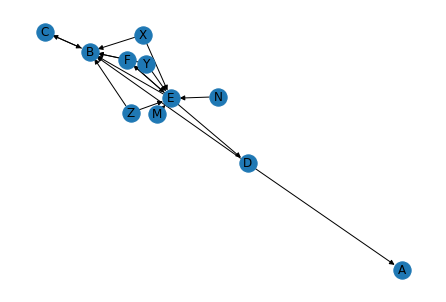

In [ ]:
# imports
import re
import heapq
import itertools
import numpy as np
import networkx as nx #
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

def get_adj_graph_from_edges_list(TOY_GRAPH):
    ADJ_GRAPH = {} #unweighted
    for node in TOY_GRAPH['nodes']:
        if node not in ADJ_GRAPH:
            ADJ_GRAPH[node] = []

        for edge in TOY_GRAPH['edges']:
            if edge[0] == node:
                ADJ_GRAPH[node].append(edge[1])
    return ADJ_GRAPH

# a graph is a list of nodes and edges (RUN CELL AS IS)
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B', 1),
         ('A', 'E', 5),
         ('B', 'A', 2),
         ('B', 'C', 4),
         ('B', 'D', 2),
         ('B', 'E', 6),
         ('C', 'B', 5),
         ('C', 'D', 2),
         ('D', 'B', 7),
         ('D', 'C', 3),
         ('D', 'E', 3),
         ('E', 'A', 4),
         ('E', 'B', 1),
         ('E', 'D', 5),]
TOY_GRAPH = {'nodes' : nodes, 'edges' : edges}

print("Graph as adjecency list")
print(get_adj_graph_from_edges_list(TOY_GRAPH))

edges_str = """D A
D B
X B
X E
Y B
Y E
Z B
Z E
M E
N E
F E
E F
F B
B C
C B
E B
E D"""
edges = [re.split("\s+", edge) for edge in edges_str.split("\n") ]
nodes = set([node for edge in edges_str.split("\n") for node in re.split("\s+", edge)])
print(f"nodes: {nodes}")
print(f"edges:{edges}")
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels = True, pos=nx.spring_layout(G))
page_rank = nx.pagerank(G, alpha=0.85)
page_rank = sorted(page_rank.items(), key=lambda x:-x[1])
print("\n".join([f"{node},{round(page_rank, 3)}" for node,page_rank in page_rank]))

A better visualization from [Wikipedia](https://en.wikipedia.org/wiki/PageRank)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/PageRanks-Example.svg/330px-PageRanks-Example.svg.png">



In [ ]:
### PageRank
import re
import sys
from operator import add
from typing import Mapping,Tuple
from pyspark.resultiterable import ResultIterable
from pyspark.sql import SparkSession


def parse_directed_edge_node(edge: str) -> Tuple[str, str]:
    """Parses a urls pair string into urls pair.
    node[0] --> node[1]"""
    nodes = re.split(r'\s+', edge)
    return nodes[0], nodes[1]

def extract_nodes(urls: str):
    """output nodes in an edge"""
    parts = re.split(r'\s+', urls)
    yield parts[0]
    yield parts[1]

def assign_PR_mass_to_nbors_or_to_dangling_mass(node, page_rank_mass, outlinks, dangling_node_mass): # -> Iterable[Tuple[str, float]]:
    """ distribute the pagerank mass for a node to the neighbors it points to (its outlinks).
        Or if there is no outgoing link add the pagerank mass to the dangling mass"""
    if outlinks: # Redistribute  mass of node amongst neigbbors (outgoing links)
        num_of_outlinks = len(outlinks)
        for outlink in outlinks:
            yield (outlink, page_rank_mass / num_of_outlinks)
    else: # accumulate dangling mass as there are no outgoing links for this node
        dangling_node_mass += page_rank_mass
    yield node, 0.0

edges_str = """1 2
1 3
1 4
2 1
3 1
4 3
4 1"""

edges_str = """D A
D B
X B
X E
Y B
Y E
Z B
Z E
M E
N E
F E
E F
F B
B C
C B
E B
E D"""
iterations = 100
alpha = 0.15
edges_rdd = sc.parallelize(list(edges_str.split("\n")))
print(f"edges_rdd: {edges_rdd.collect()}")
# Loads all URLs from input file and initialize their neighbors.
graph_adjacency_list = edges_rdd.map(lambda edge: parse_directed_edge_node(edge)).distinct().groupByKey().cache()
print(f"graph_adjacency_list---------")
for node_and_neighbors in graph_adjacency_list.collect():
  print(f"Node {node_and_neighbors[0]}: {','.join(node_and_neighbors[1])} ")

# graph_adjacency_list.collect()[0][0]
# Loads all URLs from input file and initialize their neighbors.
unique_nodes = edges_rdd.flatMap(lambda edge: extract_nodes(edge)).distinct()
unique_nodes_count = unique_nodes.count()
print(f"unique_nodes_count: {unique_nodes_count}.  unique_nodes: {unique_nodes.collect()};  ")
#.map(lambda url: (url, 1.0))
page_rank = unique_nodes.map(lambda url: (url, 1.0/unique_nodes_count))
print(f"Initialized page_rank: ")
page_rank_sorted = sorted(page_rank.collect(), key=lambda x:-x[1])
print("\n".join([f"{node},{round(page_rank, 3)}" for node,page_rank in page_rank_sorted]))

teleportation_factor = alpha/unique_nodes_count

# Iteratively, update the pagerank of each URL using PageRank algorithm.
from tqdm import tqdm # progress bar

for iteration in tqdm(range(iterations)): # progress bar
    # Accumulate page rank mass from all incoming links
    # Accumulate mass from deadend nodes
    dangling_node_mass = sc.accumulator(float(0.0))
    pr_mass_from_nbors = page_rank.leftOuterJoin(graph_adjacency_list)\
         .flatMap(lambda url_urls_rank: assign_PR_mass_to_nbors_or_to_dangling_mass(url_urls_rank[0], url_urls_rank[1][0], url_urls_rank[1][1], dangling_node_mass) )
    dangling_node_mass_per_node = dangling_node_mass.value/unique_nodes_count
    # Accumulate page rank mass from all incoming links, dangling node mass, and from the teleportation graph
    page_rank = pr_mass_from_nbors.reduceByKey(add).mapValues(lambda rank: (dangling_node_mass_per_node + rank) * (1.0 - alpha) + teleportation_factor)

# Print each node/URL and corresponding page rank
page_rank = sorted(page_rank.collect(), key=lambda x:-x[1])
print("\n".join([f"{node},{round(page_rank, 3)}" for node,page_rank in page_rank]))

edges_rdd: ['D A', 'D B', 'X B', 'X E', 'Y B', 'Y E', 'Z B', 'Z E', 'M E', 'N E', 'F E', 'E F', 'F B', 'B C', 'C B', 'E B', 'E D']
graph_adjacency_list---------
Node N: E 
Node C: B 
Node D: A,B 
Node X: B,E 
Node Y: B,E 
Node Z: B,E 
Node M: E 
Node F: E,B 
Node E: F,B,D 
Node B: C 
unique_nodes_count: 11.  unique_nodes: ['N', 'C', 'D', 'A', 'B', 'X', 'E', 'Y', 'Z', 'M', 'F'];  
Initialized page_rank: 
N,0.091
C,0.091
D,0.091
A,0.091
B,0.091
X,0.091
E,0.091
Y,0.091
Z,0.091
M,0.091
F,0.091


Py4JJavaError: ignored

In [ ]:
page_rank.collect()

[('Z', 0.013636363636363636),
 ('Y', 0.013636363636363636),
 ('X', 0.013636363636363636),
 ('M', 0.013636363636363636),
 ('A', 0.027645934714267257),
 ('F', 0.03296369665389087),
 ('N', 0.013636363636363636),
 ('C', 0.2891898675688409),
 ('E', 0.06821411653244908),
 ('B', 0.32418057298066155),
 ('D', 0.03296369665389087)]

In [ ]:
from tqdm import tqdm

def fit_with_progress_bar(estimator, X, y):
    """Wrap the fit method of a GridSearchCV object with tqdm progress bar

    Parameters
    ----------
    estimator : GridSearchCV
        The GridSearchCV object to wrap the fit method of.
    X : array-like of shape (n_samples, n_features)
        The input data.
    y : array-like of shape (n_samples,)
        The target values.

    Returns
    -------
    GridSearchCV
        The fitted GridSearchCV object.
    """
    with tqdm(total=len(estimator.param_grid)) as pbar:
        def update_pbar(results):
            pbar.update()
            return results
        estimator.estimator.steps[-1][1].set_params(estimator__callback=update_pbar)
        return estimator.fit(X, y)


from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from tqdm import tqdm

# Generate some sample data
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('svm', MultiOutputClassifier(SVC(max_iter=50)))
])

# Define the parameter grid
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'svm__estimator__C': [0.1, 1, 10],
    'svm__estimator__kernel': ['linear', 'rbf']
}

# Define the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5)

# Fit the GridSearchCV object with progress bar
fit_with_progress_bar(grid_search, X, y)


  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: ignored